<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_2_deep_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
#install GluonTS
!pip install --upgrade mxnet~=1.7 gluonts

In [3]:
#metatrader 5 history file an timeframe is ok
df = pd.read_csv('/content/EURUSD_H4_200001030000_202202030000.csv')


In [4]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [5]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,2000.01.03,00:00:00,1.00730,1.01900,1.00730,1.01750,670,0,50
1,2000.01.03,04:00:00,1.01730,1.01810,1.01540,1.01570,609,0,50
2,2000.01.03,08:00:00,1.01540,1.01670,1.00930,1.01150,1731,0,50
3,2000.01.03,12:00:00,1.01180,1.01180,1.00540,1.00730,1562,0,50
4,2000.01.03,16:00:00,1.00770,1.02400,1.00700,1.02180,1484,0,50
...,...,...,...,...,...,...,...,...,...
34395,2022.02.02,08:00:00,1.12732,1.12942,1.12667,1.12932,11753,0,0
34396,2022.02.02,12:00:00,1.12931,1.13301,1.12897,1.13112,17083,0,0
34397,2022.02.02,16:00:00,1.13115,1.13212,1.12926,1.13113,18868,0,0
34398,2022.02.02,20:00:00,1.13112,1.13142,1.13020,1.13035,6153,0,0


In [6]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                0         1        5
0      2000.01.03  00:00:00  1.01750
1      2000.01.03  04:00:00  1.01570
2      2000.01.03  08:00:00  1.01150
3      2000.01.03  12:00:00  1.00730
4      2000.01.03  16:00:00  1.02180
...           ...       ...      ...
34395  2022.02.02  08:00:00  1.12932
34396  2022.02.02  12:00:00  1.13112
34397  2022.02.02  16:00:00  1.13113
34398  2022.02.02  20:00:00  1.13035
34399  2022.02.03  00:00:00  1.13010

[34400 rows x 3 columns]


In [7]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [8]:
new_df = new_df.rename(columns={5:'price'})

In [9]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2000-01-03 00:00:00  1.01750
2000-01-03 04:00:00  1.01570
2000-01-03 08:00:00  1.01150
2000-01-03 12:00:00  1.00730
2000-01-03 16:00:00  1.02180
...                      ...
2022-02-02 08:00:00  1.12932
2022-02-02 12:00:00  1.13112
2022-02-02 16:00:00  1.13113
2022-02-02 20:00:00  1.13035
2022-02-03 00:00:00  1.13010

[34400 rows x 1 columns]


In [10]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34400 entries, 2000-01-03 00:00:00 to 2022-02-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   34400 non-null  float64
dtypes: float64(1)
memory usage: 537.5 KB


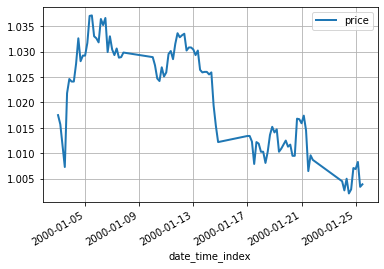

In [11]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [12]:
#import Gluon
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [13]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2000-01-01 01:00:00":"2022-02-03 00:00:00"]}], 
    freq = "4H"
    )

In [14]:
#import model 
from gluonts.model.deepar import DeepAREstimator

from gluonts.model.deep_factor._network import DeepFactorPredictionNetwork, DeepFactorTrainingNetwork
from gluonts.model.deep_factor.RNNModel import RNNModel

from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.mx.trainer import Trainer

In [29]:
#train model
estimator = DeepFactorEstimator(freq="4H", prediction_length=24,  batch_size=24, trainer=Trainer(epochs=20, num_batches_per_epoch=2000))
#estimator = DeepFactorEstimator(freq="1H", prediction_length=124, trainer=Trainer(epochs=3))

predictor = estimator.train(training_data=training_data)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████| 2000/2000 [00:23<00:00, 85.13it/s, epoch=20/20, avg_epoch_loss=-6.53]


In [30]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-02-03 00:00:00"]}],
    freq = "4H"
)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


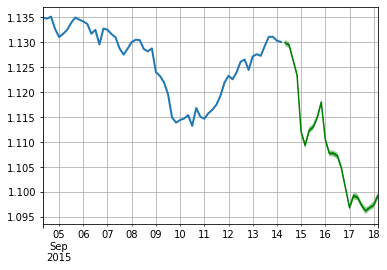

In [31]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

In [18]:
from gluonts.evaluation import make_evaluation_predictions

In [19]:

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


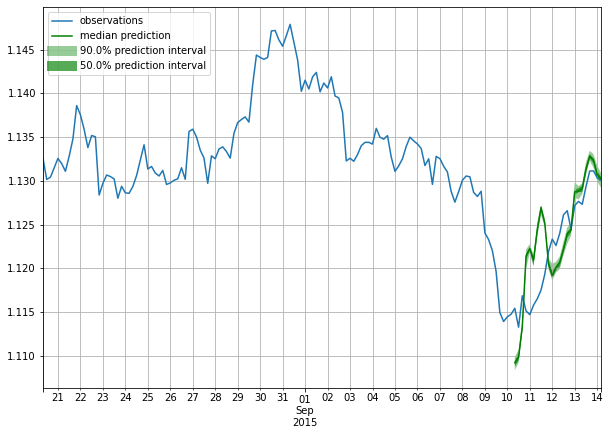

In [20]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=24,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])